## ch3 ARIMA

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right\"> Initial upload: 2022.09.09 </div>
<div style="text-align: right\"> Last update: 2022.09.09</div>

In [60]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [61]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product

from statsmodels.tsa.arima_model import ARIMA

In [62]:
colors = ["#00798c", "#d1495b", '#edae49', '#66a182', '#4a4a4a',
          '#1a508b', '#e3120b', '#c5a880', '#9F5F80', '#6F9EAF',
          '#0278ae','#F39233', '#A7C5EB', '#54E346', '#ABCE74',
        '#d6b0b1', '#58391c', '#cdd0cb', '#ffb396', '#6930c3']
sns.color_palette(colors[:10])

[(0.0, 0.4745098039215686, 0.5490196078431373),
 (0.8196078431372549, 0.28627450980392155, 0.3568627450980392),
 (0.9294117647058824, 0.6823529411764706, 0.28627450980392155),
 (0.4, 0.6313725490196078, 0.5098039215686274),
 (0.2901960784313726, 0.2901960784313726, 0.2901960784313726),
 (0.10196078431372549, 0.3137254901960784, 0.5450980392156862),
 (0.8901960784313725, 0.07058823529411765, 0.043137254901960784),
 (0.7725490196078432, 0.6588235294117647, 0.5019607843137255),
 (0.6235294117647059, 0.37254901960784315, 0.5019607843137255),
 (0.43529411764705883, 0.6196078431372549, 0.6862745098039216)]

In [27]:
def load_dexcom_data(path, sampling_time='5min'):
    df = pd.read_csv(path)
    df = df[df['타임스탬프(YYYY-MM-DDThh:mm:ss)'].notnull()]
    df = df.iloc[:,[1, 7]]
    df.columns = ['timestamp', 'glucose']
    df = df.reset_index(drop = True)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['timestamp'] = df['timestamp'].dt.round(sampling_time)
    df = df.dropna()
    idx = pd.date_range(df['timestamp'].min(), df['timestamp'].max(), freq=sampling_time)
    df = df.set_index('timestamp').reindex(idx, fill_value=np.nan).reset_index().rename(columns = {'index': 'timestamp'})
    
    return df

In [28]:
def series_to_supervised(data, n_in=1, n_out=1, col_name = 'glucose', dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]

    cols, names = list(), list()
	# input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(data.shift(i))
        names += [(col_name+'(t-%d)' % (i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(data.shift(-i))
        if i == 0:
            names += [col_name+'(t)']
        else:
            names += [(col_name+'(t+%d)' % (i)) for j in range(n_vars)]
	# put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### 1. 데이터 셋 만들기

In [29]:
path = 'dexcom_sample.csv'
cgm = load_dexcom_data(path)
cgm['glucose_diff'] = cgm['glucose'].diff()
cgm = cgm.dropna()
df_sv = series_to_supervised(cgm[['glucose']], n_in=4, n_out = 4, dropnan = False)
df_sv['timestamp'] = cgm['timestamp']
df_sv = df_sv.dropna().reset_index(drop = True)
# 일부만 추출
df_sv = df_sv.set_index('timestamp').loc[:'2022-06-10 21:15'].reset_index(drop=False)

In [30]:
df_sv.shape

(2760, 9)

In [31]:
df_sv.head()

,timestamp,glucose(t-4),glucose(t-3),glucose(t-2),glucose(t-1),glucose(t),glucose(t+1),glucose(t+2),glucose(t+3)
0,2022-06-01 07:20:00,122.0,125.0,128.0,129.0,129.0,130.0,128.0,127.0
1,2022-06-01 07:25:00,125.0,128.0,129.0,129.0,130.0,128.0,127.0,124.0
2,2022-06-01 07:30:00,128.0,129.0,129.0,130.0,128.0,127.0,124.0,124.0
3,2022-06-01 07:35:00,129.0,129.0,130.0,128.0,127.0,124.0,124.0,130.0
4,2022-06-01 07:40:00,129.0,130.0,128.0,127.0,124.0,124.0,130.0,137.0


In [32]:
train_index = 2735

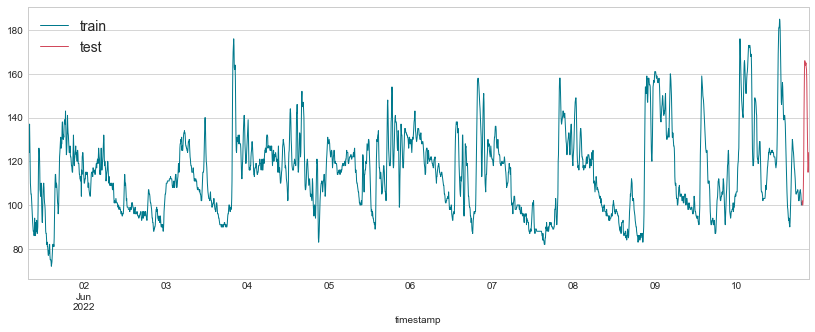

In [33]:
fig, ax = plt.subplots(figsize = (14, 5))
df_sv[:train_index].set_index('timestamp')['glucose(t)'].plot(ax = ax, color = colors[0],
                                                       linewidth=1, label = 'train')
df_sv[train_index:].set_index('timestamp')['glucose(t)'].plot(ax = ax, color = colors[1], 
                                                       linewidth=1, label = 'test')
plt.legend(fontsize = 14)
plt.show()

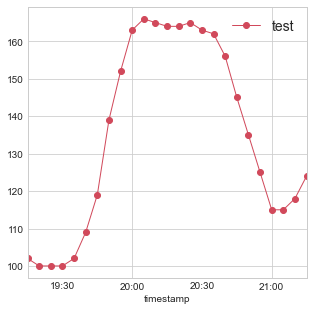

In [34]:
fig, ax = plt.subplots(figsize = (5, 5))
# df_sv[:2735].set_index('timestamp')['glucose(t)'].plot(ax = ax, color = colors[0],
#                                                        linewidth=1, label = 'train')
df_sv[train_index:].set_index('timestamp')['glucose(t)'].plot(ax = ax, color = colors[1], 
                                                       linewidth=1, marker = 'o',
                                                       label = 'test')
plt.legend(fontsize = 14)
plt.show()

In [35]:
train = df_sv[['timestamp', 'glucose(t)']][:train_index]
test = df_sv[['timestamp', 'glucose(t)']][train_index:]

In [36]:
train.head()

,timestamp,glucose(t)
0,2022-06-01 07:20:00,129.0
1,2022-06-01 07:25:00,130.0
2,2022-06-01 07:30:00,128.0
3,2022-06-01 07:35:00,127.0
4,2022-06-01 07:40:00,124.0


In [37]:
train.tail()

,timestamp,glucose(t)
2730,2022-06-10 18:50:00,106.0
2731,2022-06-10 18:55:00,105.0
2732,2022-06-10 19:00:00,102.0
2733,2022-06-10 19:05:00,100.0
2734,2022-06-10 19:10:00,101.0


In [38]:
print(train.shape)
print(test.shape)

(2735, 2)
(25, 2)


### 2. p, d, q 찾기

In [39]:
ps = range(0, 5, 1)
qs = range(0, 5, 1)
ds = range(0, 2, 1)

order_list = list(product(ps, ds, qs))
order_list

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 0, 4),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (2, 0, 4),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (3, 0, 0),
 (3, 0, 1),
 (3, 0, 2),
 (3, 0, 3),
 (3, 0, 4),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3),
 (3, 1, 4),
 (4, 0, 0),
 (4, 0, 1),
 (4, 0, 2),
 (4, 0, 3),
 (4, 0, 4),
 (4, 1, 0),
 (4, 1, 1),
 (4, 1, 2),
 (4, 1, 3),
 (4, 1, 4)]

In [43]:
from typing import Union

def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], order[1], order[2]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,d, q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [44]:
result = optimize_ARIMA(train['glucose(t)'], order_list)

  0%|          | 0/50 [00:00<?, ?it/s]

In [45]:
result

,"(p,d, q)",AIC
0,"(4, 1, 3)",12750.441986
1,"(4, 1, 1)",12759.075456
2,"(2, 1, 4)",12761.322766
3,"(1, 1, 4)",12770.993652
4,"(2, 1, 1)",12771.278911
5,"(3, 1, 1)",12771.815809
6,"(2, 1, 2)",12771.932085
7,"(3, 1, 2)",12772.389422
8,"(2, 1, 3)",12773.085138
9,"(4, 1, 2)",12773.608138


- p, d, q 를 (4, 1, 3)으로 설정

In [46]:
model = SARIMAX(train['glucose(t)'], order=(4,1,3), simple_differencing=False)
model = model.fit(disp=False)

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:             glucose(t)   No. Observations:                 2735
Model:               SARIMAX(4, 1, 3)   Log Likelihood               -6367.221
Date:                Mon, 12 Sep 2022   AIC                          12750.442
Time:                        20:11:45   BIC                          12797.750
Sample:                             0   HQIC                         12767.539
                               - 2735                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3869      4.813      0.288      0.773      -8.047      10.821
ar.L2          0.4471     11.489      0.039      0.969     -22.072      22.966
ar.L3         -1.3914      9.339     -0.149      0.8

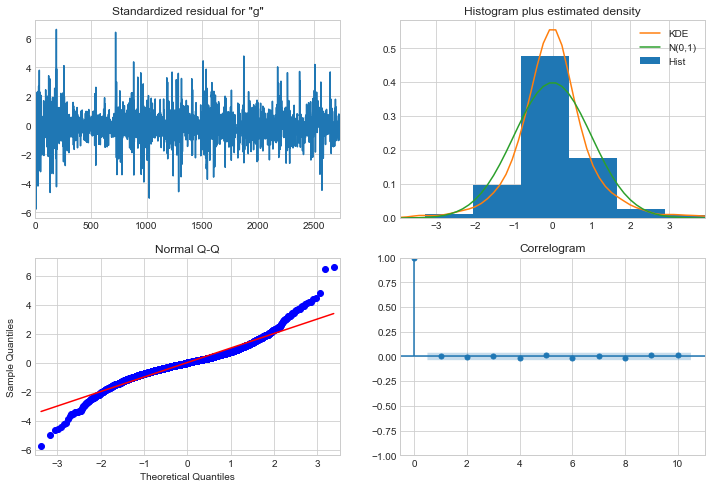

In [47]:
model.plot_diagnostics(figsize=(12,8));

### 3. ARIMA(4, 1, 3) 모델 학습하기

In [52]:
order = (4, 1, 3)
model = ARIMA(train['glucose(t)'], order=order)
model = model.fit()

In [53]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.glucose(t)   No. Observations:                 2734
Model:                 ARIMA(4, 1, 3)   Log Likelihood               -6364.462
Method:                       css-mle   S.D. of innovations              2.480
Date:                Mon, 12 Sep 2022   AIC                          12746.925
Time:                        20:15:07   BIC                          12800.146
Sample:                             1   HQIC                         12766.159
                                                                              
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0028      0.003      0.848      0.397      -0.004       0.009
ar.L1.D.glucose(t)     1.4090      0.059     23.893      0.000       1.293       1.525
ar.L2.D.glucose(t)     0.4010      0.067      6.010      0.000       0.270       0.532
ar.L3.D.glucose(t)    -1.3589      0.107    -12.737      0.000      -1.568      -1.150
ar.L4.D.glucose(t)     0.5397      0.049     11.089      0.000       0.444       0.635
ma.L1.D.glucose(t)    -0.7506      0.064    -11.775      0.000      -0.876      -0.626
ma.L2.D.glucose(t)    -0.9779      0.045    -21.698      0.000      -1.066      -0.890
ma.L3.D.glucose(t)     0.7286      0.081      8.961      0.000       0.569       0.888
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0189           -0.0000j            1.0189           -0.5000
AR.2            1.0331           -0.0000j            1.0331           -0.0000
AR.3            1.2520           -0.4391j            1.3268           -0.0537
AR.4            1.2520           +0.4391j            1.3268            0.0537
MA.1           -1.0128           +0.0000j            1.0128            0.5000
MA.2            1.0001           +0.0000j            1.0001            0.0000
MA.3            1.3548           +0.0000j            1.3548            0.0000
-----------------------------------------------------------------------------
"""

예측 수행하기

In [55]:
model.forecast(steps = 5)[0]

array([102.22654704, 103.45998141, 104.57809252, 105.5210423 ,
       106.28384154])

### 3. Multi-step forecasting

In [67]:
markers = ['X', 'D', 'v', '*', '+']
marker_colors = ['#2ca02c', 'r', 'b', 'c', 'tab:purple', 'tab:orange']
order = (4, 1, 3)

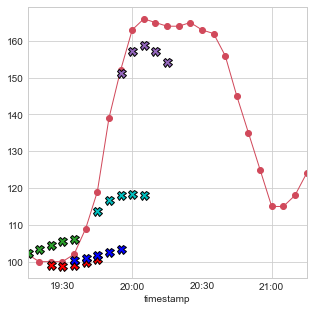

In [70]:
fig, ax = plt.subplots(figsize = (5, 5))
# df_sv[:2735].set_index('timestamp')['glucose(t)'].plot(ax = ax, color = colors[0],
#                                                        linewidth=1, label = 'train')
df_sv[train_index:].set_index('timestamp')['glucose(t)'].plot(ax = ax, color = colors[1], 
                                                       linewidth=1, marker = 'o',
                                                       label = 'test')

for i in range(5):
    model = ARIMA(df_sv['glucose(t)'][:train_index+2*i], order=order)
    model = model.fit()
    
    pred = model.forecast(steps=5)[0]#5개 step 예측
    df_sv['pred'] = np.nan
    df_sv.iloc[train_index+2*i:train_index+2*i+5]['pred']= pred
    
    df_sv[train_index:].set_index('timestamp')['pred'].plot(ax = ax, linewidth=0, 
                                                            marker='X', 
                                                       label='Predictions',
                                                       markersize = 9,
                                                       markeredgecolor = 'k',
                                                       color=marker_colors[i])